In [2]:
#make a hidden directory named .kaggle if it doesn't already exist
!mkdir -p ~/.kaggle
#copy kaggle.json (I uploaded this API-file previously) into .kaggle
!cp kaggle.json ~/.kaggle/
#change mode to allow only the owner (me) to read and write this file
!chmod 600 ~/.kaggle/kaggle.json
#load the kaggle dataset into my cwd (current working directory) which is /content/
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
#unzip the file quietly (so that it doesn't print 60000 lines)
!unzip -qo cifake-real-and-ai-generated-synthetic-images.zip
#count the number of files in the train folder
!find train -type f | wc -l


Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.65GB/s]
100000


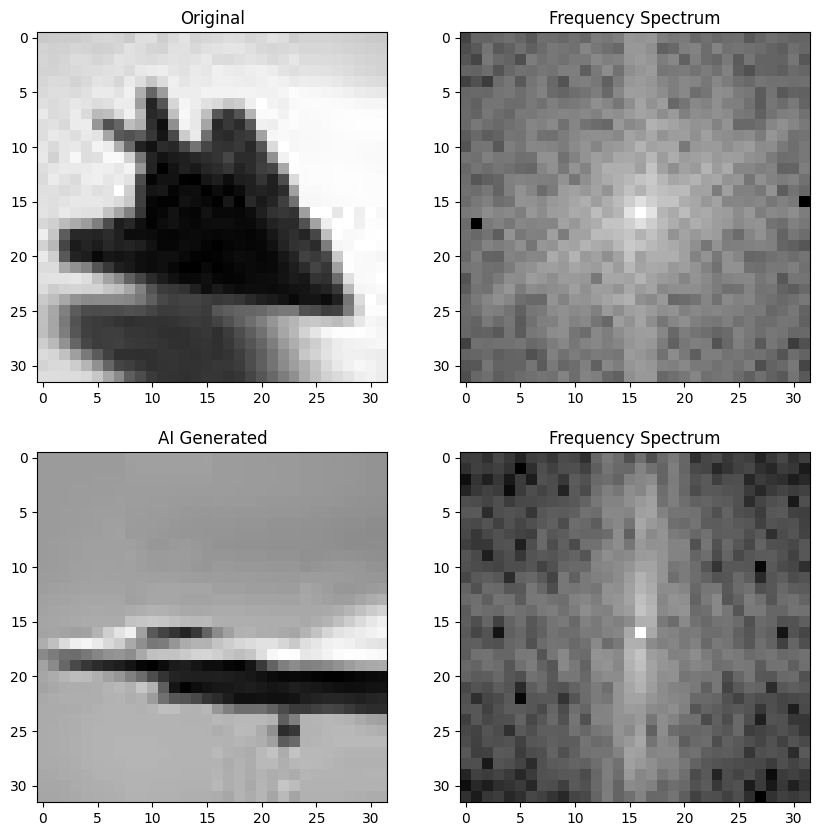

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

#creating a function to convert an image from the spatial domain to the frequency domain representation
def get_fft_spectrum(img_path):
  #load the image in grayscale
  img = cv2.imread(img_path, 0)
  #calculate the 2D fast fourier transform of the image
  f = np.fft.fft2(img)
  #shift the (0,0) pixel to the center by swaping the top-left quadrant to the bottom-right quadrant
  #and the top-right quandrant to the bottom-left quadrant
  fshift = np.fft.fftshift(f)
  #take the absolute value because fshit gives complex numbers, we then take the log to scale down the big values
  #we then multiply by 20 to have a better visual
  magnitude_spectrum = 20 * np.log(np.abs(fshift))
  return img, magnitude_spectrum

real_sample = 'train/REAL/0000.jpg'
fake_sample = 'train/FAKE/1000.jpg'

#create 4 subplots with the size of the window equals to 10 by 10 inches
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

#iterate over the images
for i, path in enumerate([real_sample, fake_sample]):
  #get the fourier transform of the images
  img, spec = get_fft_spectrum(path)
  #show the actual image in grayscale
  axs[i, 0].imshow(img, cmap = 'gray')
  axs[i, 0].set_title("Original" if i == 0 else "AI Generated")
  #show the frequency spectrum in grayscale
  axs[i, 1].imshow(spec, cmap = 'gray')
  axs[i, 1].set_title('Frequency Spectrum')



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

#we implement a pre-processing (transform) pipeline so we adjust the images of the dataset
transform = transforms.Compose([
    #resize the image to 224*224 pixels which is a standard format of inputs of a ResNet
    transforms.Resize((224, 224)),
    #transform the image into a tensor that has as dimension [3, 224, 224]
    transforms.ToTensor(),
    #newpixel = (old - mean)/std, normalize using ImageNet mean/std to match the distribution the model was pre-trained on
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#store the dataset 'transformed' by our pipeline
full_dataset = datasets.ImageFolder('train', transform = transform)

#calculate the sizes of the training and testing set
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

#split the data into a training and testing set with an 80/20 split
train_data, test_data = random_split(full_dataset, [train_size, test_size])

#set up a dataloader, with shuffle so that the model gets real and fake images randomly
#and num_workers set to 2 so that 2 CPU sub-processes work in parallel
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = True, num_workers = 2)

In [ ]:
#detecting the device we're using
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#storing the ResNet model trained (on IMAGENET1K_V1) that we're going to fine-tune on our specific dataset
model = models.resnet18(weights='IMAGENET1K_V1')
#replacing the pre-trained ImageNet head (1000 classes) with a binary classifier (Real vs Fake)
model.fc = nn.Linear(model.fc.in_features, 2)

#iterate of the layers of Resnet, if we are NOT in the 3rd, 4th or fully connected layer, freeze the weights to
#have less computations and it's faster to train
for name, param in model.named_parameters():
  if any(x in name for x in {'layer3', 'layer4', 'fc'}):
    param.requires_grad = True
  else:
    param.requires_grad = False

#define the optimizer of our neural network, we use filter to remove the frozen weights
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.01)

#move the model to the GPU (or CPU)
model = model.to(device)

#defining the loss function, we used cross entropy loss since it's a binary classificaiton problem
criterion = nn.CrossEntropyLoss()

#activate training mode
model.train()

for epoch in range(6):
  print(f'Epoch : {epoch + 1}')
  for batch_idx, (inputs, labels) in enumerate(train_loader):
    #move the inputs and labels to the GPU (or CPU)
    inputs, labels = inputs.to(device), labels.to(device)
    #Reset gradients
    optimizer.zero_grad()
    #forward pass
    outputs = model(inputs)
    #compute the loss
    loss = criterion(outputs, labels)
    #backprop
    loss.backward()
    #update weights
    optimizer.step()
    if batch_idx % 500 == 0:
      print(f'batch : {batch_idx} | loss : {loss.item():.4f}')


Epoch : 1
batch : 0 | loss : 0.8410
batch : 500 | loss : 0.1814
batch : 1000 | loss : 0.1923
batch : 1500 | loss : 0.2199
batch : 2000 | loss : 0.1767
Epoch : 2
batch : 0 | loss : 0.1312
batch : 500 | loss : 0.0403
batch : 1000 | loss : 0.2141
batch : 1500 | loss : 0.1329
batch : 2000 | loss : 0.2021
Epoch : 3
batch : 0 | loss : 0.0565
batch : 500 | loss : 0.1491
batch : 1000 | loss : 0.0961
batch : 1500 | loss : 0.0343
batch : 2000 | loss : 0.0851
Epoch : 4
batch : 0 | loss : 0.0251
batch : 500 | loss : 0.1818
batch : 1000 | loss : 0.2372
batch : 1500 | loss : 0.0975
batch : 2000 | loss : 0.0235
Epoch : 5
batch : 0 | loss : 0.0206
batch : 500 | loss : 0.1868
batch : 1000 | loss : 0.1069
batch : 1500 | loss : 0.0452
batch : 2000 | loss : 0.1091
Epoch : 6
batch : 0 | loss : 0.1460
batch : 500 | loss : 0.1079
batch : 1000 | loss : 0.0329
batch : 1500 | loss : 0.0387
batch : 2000 | loss : 0.0437


In [9]:
#activate evaluation mode
model.eval()

#count the number of correct predictions
correct = 0
total = 0

#don't compute the gradient since we're in evaluation mode
with torch.no_grad():
  for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    #Get the class index with the highest score for each image in the batch
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    if batch_idx % 100 == 0:
      curr_acc = 100 * correct / total
      print(f'batch : {batch_idx} | current accuracy : {curr_acc:.2f}%')
acc = 100 * correct / total
print(f'Accuracy = {acc:.2f}%')

batch : 0 | current accuracy : 93.75%
batch : 100 | current accuracy : 95.45%
batch : 200 | current accuracy : 95.54%
batch : 300 | current accuracy : 95.50%
batch : 400 | current accuracy : 95.43%
batch : 500 | current accuracy : 95.65%
batch : 600 | current accuracy : 95.62%
Accuracy = 95.64%
